In [13]:
# import the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the full csv with 15 years of data
data = pd.read_csv("../data/premier_league_omega.csv")

# 📊 Premier League Part 5: The "Per Game" Deep Dive

## Advanced Analytics Beyond Simple League Tables

Welcome to the most sophisticated analysis in our Premier League series. While Parts 3-4 focused on champions and season winners, **Part 5 explores the underlying performance metrics that reveal team quality beyond just results**.

### What Makes This Analysis Different:

**Traditional Analysis Limitations:**
- Standard league tables only show final positions
- Total stats favor teams with more seasons in the Premier League
- No normalization for games played creates bias toward longevity

**Our Advanced Approach:**
- **Per-game metrics** create fair comparisons across all teams
- **Multiple performance dimensions** beyond just wins/losses
- **Visual correlation analysis** to understand what drives success
- **Style-based insights** revealing how different teams approach the game

This analysis will answer questions like: "*Who scores the most goals per game over 15 years?*" and "*What's the relationship between shots and actual goals?*"

In [16]:
pl_15years = data.copy()
pl_15years["date"] = pd.to_datetime(pl_15years["date"], format="mixed", dayfirst=True, errors="coerce")


def add_season_end_year(df, date_col="date"):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    
    # For matches from August–December, the season ends the next year.
    # For matches from January–May, it ends in the same year.
    df["season"] = df[date_col].apply(lambda d: d.year + 1 if d.month >= 8 else d.year)
    
    if "division" in df.columns:
        df = df.drop(columns=["division"])
    
    return df

# Apply it:
pl_15years = add_season_end_year(pl_15years)

def season_table(df, season_end_year: int, season_col: str = "season"):
    """Return one season’s league table (e.g., season_end_year=2026)."""
    return mega_league_table(df[df[season_col] == season_end_year])
def all_season_tables(df, season_col: str = "season"):
    """Dict: {season_end_year -> league table}."""
    return {s: mega_league_table(g) for s, g in df.groupby(season_col)}
def season_panel(df, season_col: str = "season"):
    """One DataFrame with season + team index for easy querying/plotting."""
    out = []
    for s, g in df.groupby(season_col):
        t = mega_league_table(g).reset_index().rename(columns={"index":"team"})
        t["season"] = s
        out.append(t)
    panel = pd.concat(out, ignore_index=True)
    return panel.set_index(["season","team"]).sort_index()
def mega_league_table(df):
    table = pd.DataFrame()

    # Home stats
    home = df.groupby("home_team").agg(
        played_home=("home_team", "count"),
        wins_home=("full_time_result", lambda x: (x=="H").sum()),
        draws_home=("full_time_result", lambda x: (x=="D").sum()),
        losses_home=("full_time_result", lambda x: (x=="A").sum()),
        gf_home=("full_time_home_goals", "sum"),
        ga_home=("full_time_away_goals", "sum"),
        shots_home=("home_shots", "sum"),
        shots_on_target_home=("home_shots_on_target", "sum"),
        yellows_home=("home_yellow_cards", "sum"),
        reds_home=("home_red_cards", "sum")        
    )

    # Away stats
    away = df.groupby("away_team").agg(
        played_away=("away_team", "count"),
        wins_away=("full_time_result", lambda x: (x=="A").sum()),
        draws_away=("full_time_result", lambda x: (x=="D").sum()),
        losses_away=("full_time_result", lambda x: (x=="H").sum()),
        gf_away=("full_time_away_goals", "sum"),
        ga_away=("full_time_home_goals", "sum"),
        shots_away=("away_shots", "sum"),
        shots_on_target_away=("away_shots_on_target", "sum"),
        yellows_away=("away_yellow_cards", "sum"),
        reds_away=("away_red_cards", "sum")        
    )

    # Combine
    table = home.join(away, how="outer")
    table = table.fillna(0)

    table["played"] = table["played_home"] + table["played_away"]
    table["wins"] = table["wins_home"] + table["wins_away"]
    table["draws"] = table["draws_home"] + table["draws_away"]
    table["losses"] = table["losses_home"] + table["losses_away"]
    table["goals_for"] = table["gf_home"] + table["gf_away"]
    table["goals_against"] = table["ga_home"] + table["ga_away"]
    table["goal_difference"] = table["goals_for"] - table["goals_against"]
    table["points"] = table["wins"]*3 + table["draws"]
    table["total_shots"] = table["shots_home"] + table["shots_away"]
    table["total_shots_on_target"] = table["shots_on_target_home"] + table["shots_on_target_away"]
    table["total_yellows"] = table["yellows_home"] + table["yellows_away"]
    table["total_reds"] = table["reds_home"] + table["reds_away"]


    table = table[["played","wins","draws","losses","goals_for","goals_against","goal_difference","total_shots","total_shots_on_target","total_yellows","total_reds","points"]]
    return table.sort_values(by=["points","goal_difference","goals_for"], ascending=[False,False,False])

    # 

omega_table = mega_league_table(pl_15years)

In [18]:
single_season = season_table(pl_15years, 2016)
omega_table

,played,wins,draws,losses,goals_for,goals_against,goal_difference,total_shots,total_shots_on_target,total_yellows,total_reds,points
home_team,,,,,,,,,,,,
Man City,614,409,106,99,1389.0,556.0,833.0,10171.0,4171.0,934.0,37.0,1333
Liverpool,614,351,143,120,1211.0,649.0,562.0,10058.0,4071.0,872.0,35.0,1196
Arsenal,614,345,130,139,1161.0,673.0,488.0,8958.0,3744.0,970.0,55.0,1165
Chelsea,614,334,139,141,1118.0,656.0,462.0,9571.0,3895.0,1060.0,44.0,1141
Man United,614,335,136,143,1063.0,670.0,393.0,8691.0,3665.0,1082.0,34.0,1141
Tottenham,614,317,126,171,1080.0,739.0,341.0,9052.0,3853.0,1037.0,35.0,1077
Everton,614,224,179,211,801.0,794.0,7.0,7661.0,3110.0,1035.0,44.0,851
Newcastle,538,193,128,217,718.0,787.0,-69.0,6641.0,2551.0,913.0,41.0,707
West Ham,576,185,146,245,756.0,890.0,-134.0,6917.0,2590.0,950.0,39.0,701


## 🧮 The "Per Game" Revolution: Fair Comparisons Across 15 Years

### Why Per-Game Metrics Matter

**The Problem with Raw Totals:**
Manchester City and Chelsea have played 15 full Premier League seasons, accumulating massive total statistics. Meanwhile, teams like Brentford or Brighton have only played a few seasons, making direct comparison impossible.

**The Solution - Normalization:**
By calculating statistics "per game," we create a level playing field where:
- **Goals per game** shows attacking efficiency regardless of seasons played
- **Shots per game** reveals playing style and ambition  
- **Cards per game** indicates discipline and defensive approach

### Key Metrics We'll Analyze:

1. **Attacking Metrics:** Goals for/against per game, goal difference
2. **Playing Style:** Total shots, shots on target per game
3. **Discipline:** Yellow and red cards per game
4. **Overall Quality:** Points per game (the ultimate measure)

This approach reveals which teams have been consistently excellent when they've been in the Premier League, regardless of how long they've been there.

In [41]:
# make a copy
omega_avg = omega_table.copy()

# calculate per-game averages
for col in [
    "wins", "draws", "losses", "goals_for", "goals_against",
    "goal_difference", "total_shots", "total_shots_on_target",
    "total_yellows", "total_reds", "points"
]:
    omega_avg[f"{col}_pg"] = omega_avg[col] / omega_avg["played"]

# keep only the per-game stats if you prefer
cols_to_keep = [c for c in omega_avg.columns if "_pg" in c]
omega_avg = omega_avg[cols_to_keep]

# optional: round to two decimals for readability
omega_avg = omega_avg.round(2)

# make a copy so we don't overwrite
final_table = omega_avg.copy()

def sort_league_table(by: str = "points", ascending: bool = False):
    """
    Sort the omega league table by any column.
    """
    if by not in final_table.columns:
        raise ValueError(f"Column '{by}' not in table")
    return final_table.sort_values(by=by, ascending=ascending)

def style_league_table(df, color_by="points", title="Omega Premier League Table"):
    """
    Style the league table with gradient coloring and a custom title.
    """
    styled = (
        df.style
        .background_gradient(subset=[color_by], cmap="RdYlGn", axis=0)
        .format("{:.2f}")
        .set_caption(title)
        .set_table_styles([
            {"selector": "th.row_heading", "props": [("font-size", "14pt"), ("font-weight", "bold"), ("color", "yellow")]},
            {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16pt"), ("font-weight", "bold")]}
        ])
    )
    return styled

In [ ]:
display(style_league_table(sort_league_table(by="total_shots_on_target_pg"),
                           color_by="goals_for_pg",
                           title="Average PL Table (by goals + Shots on Target)"))

,wins_pg,draws_pg,losses_pg,goals_for_pg,goals_against_pg,goal_difference_pg,total_shots_pg,total_shots_on_target_pg,total_yellows_pg,total_reds_pg,points_pg
home_team,,,,,,,,,,,
Bolton,0.28,0.22,0.50,1.23,1.75,-0.53,12.32,6.98,1.69,0.13,1.06
Wigan,0.25,0.28,0.47,1.09,1.81,-0.72,12.21,6.80,1.75,0.08,1.03
Man City,0.67,0.17,0.16,2.26,0.91,1.36,16.57,6.79,1.52,0.06,2.17
Portsmouth,0.18,0.18,0.63,0.89,1.74,-0.84,12.26,6.68,1.89,0.13,0.74
Liverpool,0.57,0.23,0.20,1.97,1.06,0.92,16.38,6.63,1.42,0.06,1.95
Chelsea,0.54,0.23,0.23,1.82,1.07,0.75,15.59,6.34,1.73,0.07,1.86
Tottenham,0.52,0.21,0.28,1.76,1.20,0.56,14.74,6.28,1.69,0.06,1.75
Blackpool,0.26,0.24,0.50,1.45,2.05,-0.61,11.74,6.18,1.24,0.05,1.03
Arsenal,0.56,0.21,0.23,1.89,1.10,0.79,14.59,6.10,1.58,0.09,1.90


## 🎯 Multi-Dimensional League Tables: Beyond Points

### The Art of Alternative Rankings

Traditional league tables rank by points, but what if we ranked by different performance metrics? These alternative views reveal fascinating insights about team characteristics and playing philosophies.

### What Each Ranking Reveals:

**Goals + Shots on Target Ranking:**
- Identifies the most **clinically efficient** attacking teams
- Shows who converts chances at the highest rate
- Reveals teams that create quality opportunities, not just volume

**Reds + Losses Ranking:**
- Exposes **disciplinary and defensive weaknesses**
- Teams high in both metrics often struggle with emotional control
- Correlation between poor discipline and poor results

**Total Shots + Shots on Target:**
- Highlights **attacking ambition and creativity**
- Teams that shoot more often show positive, forward-thinking football
- Separates teams that "have a go" from defensive-minded sides

### The Philosophy Behind Each Table:
- **Attacking excellence** vs **defensive solidity**
- **High-intensity pressing** vs **controlled possession**
- **Risk-taking mentality** vs **pragmatic approach**

In [45]:
display(style_league_table(sort_league_table(by="total_reds_pg"),
                           color_by="losses_pg",
                           title="Average PL Table (by Reds + Losses)"))

,wins_pg,draws_pg,losses_pg,goals_for_pg,goals_against_pg,goal_difference_pg,total_shots_pg,total_shots_on_target_pg,total_yellows_pg,total_reds_pg,points_pg
home_team,,,,,,,,,,,
Hull,0.22,0.24,0.54,0.93,1.70,-0.77,10.43,3.74,1.70,0.14,0.89
Ipswich,0.11,0.26,0.63,0.95,2.16,-1.21,9.89,3.34,2.21,0.13,0.58
QPR,0.19,0.23,0.58,1.01,1.75,-0.74,13.09,5.79,1.68,0.13,0.81
Bolton,0.28,0.22,0.50,1.23,1.75,-0.53,12.32,6.98,1.69,0.13,1.06
Portsmouth,0.18,0.18,0.63,0.89,1.74,-0.84,12.26,6.68,1.89,0.13,0.74
Sunderland,0.25,0.29,0.45,1.08,1.48,-0.40,11.00,4.66,1.85,0.12,1.05
Watford,0.27,0.21,0.52,1.08,1.68,-0.60,11.22,3.55,1.88,0.10,1.02
Blackburn,0.28,0.25,0.47,1.18,1.68,-0.50,10.82,5.85,1.68,0.10,1.09
Arsenal,0.56,0.21,0.23,1.89,1.10,0.79,14.59,6.10,1.58,0.09,1.90


In [46]:
display(style_league_table(sort_league_table(by="total_shots_pg"),
                           color_by="total_shots_on_target_pg",
                           title="Average PL Table (by shots + Shots on Target)"))

,wins_pg,draws_pg,losses_pg,goals_for_pg,goals_against_pg,goal_difference_pg,total_shots_pg,total_shots_on_target_pg,total_yellows_pg,total_reds_pg,points_pg
home_team,,,,,,,,,,,
Man City,0.67,0.17,0.16,2.26,0.91,1.36,16.57,6.79,1.52,0.06,2.17
Liverpool,0.57,0.23,0.20,1.97,1.06,0.92,16.38,6.63,1.42,0.06,1.95
Chelsea,0.54,0.23,0.23,1.82,1.07,0.75,15.59,6.34,1.73,0.07,1.86
Tottenham,0.52,0.21,0.28,1.76,1.20,0.56,14.74,6.28,1.69,0.06,1.75
Arsenal,0.56,0.21,0.23,1.89,1.10,0.79,14.59,6.10,1.58,0.09,1.90
Man United,0.55,0.22,0.23,1.73,1.09,0.64,14.15,5.97,1.76,0.06,1.86
QPR,0.19,0.23,0.58,1.01,1.75,-0.74,13.09,5.79,1.68,0.13,0.81
Leeds,0.30,0.23,0.47,1.32,1.83,-0.52,12.84,4.32,2.11,0.06,1.13
Brighton,0.31,0.32,0.37,1.26,1.42,-0.16,12.77,4.25,1.69,0.07,1.25


C:\Users\tj92a\AppData\Local\Temp\ipykernel_12472\393840634.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_t = np.r_[r_t, r_t[0]]; r_l = np.r_[r_l, r_l[0]]; ang = np.r_[angles, angles[0]]


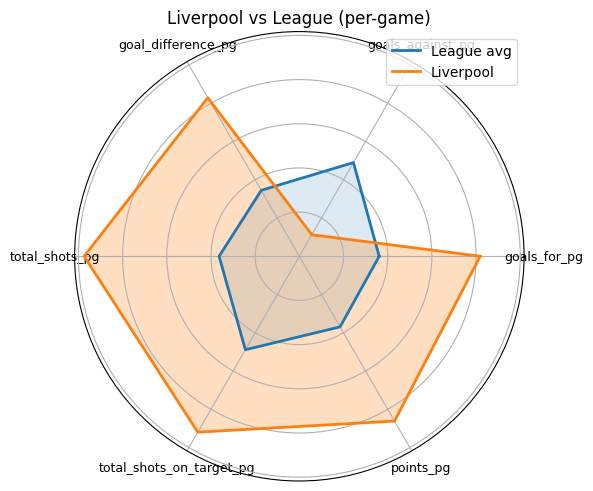

In [57]:
metrics = ["goals_for_pg","goals_against_pg","goal_difference_pg",
           "total_shots_pg","total_shots_on_target_pg","points_pg"]

def radar_team(df, team, metrics=metrics, title=None):
    row = df.loc[team, metrics]
    league = df[metrics].mean()
    # min-max scale per metric for fair comparison
    mm_min, mm_max = df[metrics].min(), df[metrics].max()
    r_t = (row - mm_min) / (mm_max - mm_min)
    r_l = (league - mm_min) / (mm_max - mm_min)

    labels = metrics
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    r_t = np.r_[r_t, r_t[0]]; r_l = np.r_[r_l, r_l[0]]; ang = np.r_[angles, angles[0]]

    fig = plt.figure(figsize=(6,6)); ax = plt.subplot(111, polar=True)
    ax.plot(ang, r_l, lw=2, label="League avg")
    ax.fill(ang, r_l, alpha=.15)
    ax.plot(ang, r_t, lw=2, label=team)
    ax.fill(ang, r_t, alpha=.25)
    ax.set_xticks(angles); ax.set_xticklabels(labels, fontsize=9)
    ax.set_yticklabels([])
    ax.set_title(title or f"{team} vs League (per-game)")
    ax.legend(loc="upper right")
    plt.tight_layout(); plt.show()

# usage
radar_team(omega_avg, "Liverpool")

## 🔗 Correlation Matrix: The Hidden Relationships in Football

### Understanding What Drives Success

Football is a complex system where multiple factors interact to determine outcomes. A correlation matrix reveals the statistical relationships between different performance metrics, helping us understand the **building blocks of Premier League success**.

### Key Relationships to Watch:

**Strong Positive Correlations (Expected):**
- **Goals For ↔ Points:** More goals = more wins (obvious but essential)
- **Shots on Target ↔ Goals:** Quality shooting accuracy matters more than volume
- **Goal Difference ↔ Points:** The ultimate measure of team quality

**Surprising Insights (Look for These):**
- **Total Shots vs Goals:** Do teams that shoot more actually score more?
- **Cards vs Performance:** Are aggressive teams more or less successful?
- **Shots on Target vs Total Shots:** Which teams are most efficient with their attempts?

### What This Analysis Reveals:

1. **Efficiency vs Volume:** Do prolific shooters score more, or is accuracy king?
2. **Discipline Impact:** How much do cards hurt team performance?
3. **Style Validation:** Which playing philosophies actually work in the Premier League?

This correlation analysis transforms raw statistics into strategic insights about what separates winners from losers in English football.

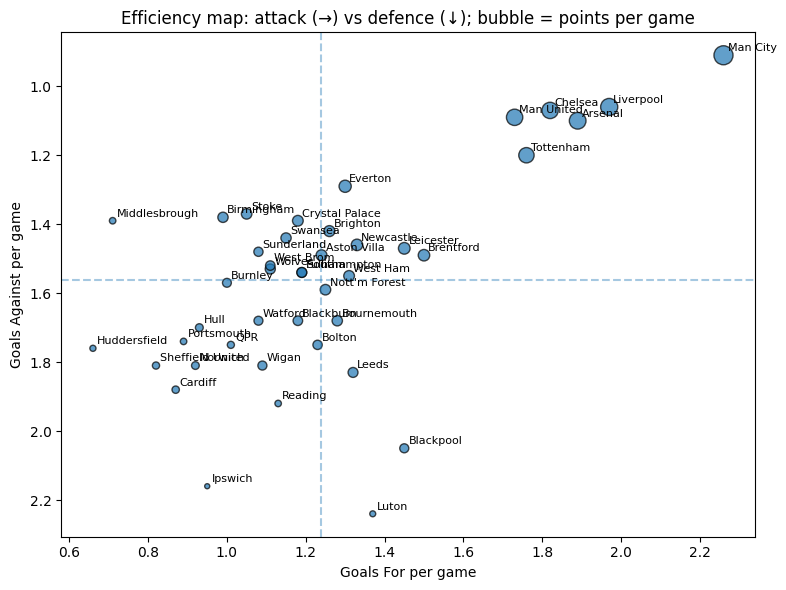

In [53]:
def efficiency_scatter(df):
    x = df["goals_for_pg"]; y = df["goals_against_pg"]; s = (df["points_pg"]**2)*40
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(x, y, s=s, alpha=.7, edgecolor="k")
    for team in df.index:
        ax.annotate(team, (x.loc[team], y.loc[team]), fontsize=8, xytext=(3,3), textcoords="offset points")
    ax.axvline(x.mean(), ls="--", alpha=.4); ax.axhline(y.mean(), ls="--", alpha=.4)
    ax.set_xlabel("Goals For per game"); ax.set_ylabel("Goals Against per game")
    ax.set_title("Efficiency map: attack (→) vs defence (↓); bubble = points per game")
    ax.invert_yaxis()  # better = up/right is good
    plt.tight_layout(); plt.show()

efficiency_scatter(omega_avg)


## 📈 Scatter Plot Deep Dive: Goals vs Shots Relationship

### The Efficiency Question: Volume vs Accuracy

This scatter plot answers one of football's fundamental questions: **"Do teams that shoot more score more goals?"** The relationship between shot volume and goal output reveals crucial insights about attacking efficiency and playing philosophy.

### What to Look for in This Visualization:

**Teams in Different Quadrants:**

1. **High Shots, High Goals (Top Right):** 
   - Elite attacking teams with both volume and efficiency
   - Usually the Premier League's top clubs
   - Perfect combination of creativity and clinical finishing

2. **High Shots, Low Goals (Bottom Right):**
   - Teams that create chances but struggle to finish
   - Often indicates poor striker quality or just bad luck
   - "All the gear, no idea" syndrome

3. **Low Shots, High Goals (Top Left):**
   - Clinical, counter-attacking teams
   - Make every chance count with ruthless efficiency
   - Often defensively solid teams that score when opportunities arise

4. **Low Shots, Low Goals (Bottom Left):**
   - Struggling teams with both creative and finishing problems
   - Usually relegation candidates or recently promoted sides
   - Indicates systemic attacking issues

### The Strategic Implications:
- **Correlation strength** shows how much shot volume actually matters
- **Outliers** reveal teams with unique playing styles or exceptional circumstances
- **Trend line** indicates the "expected" goals for any shot volume

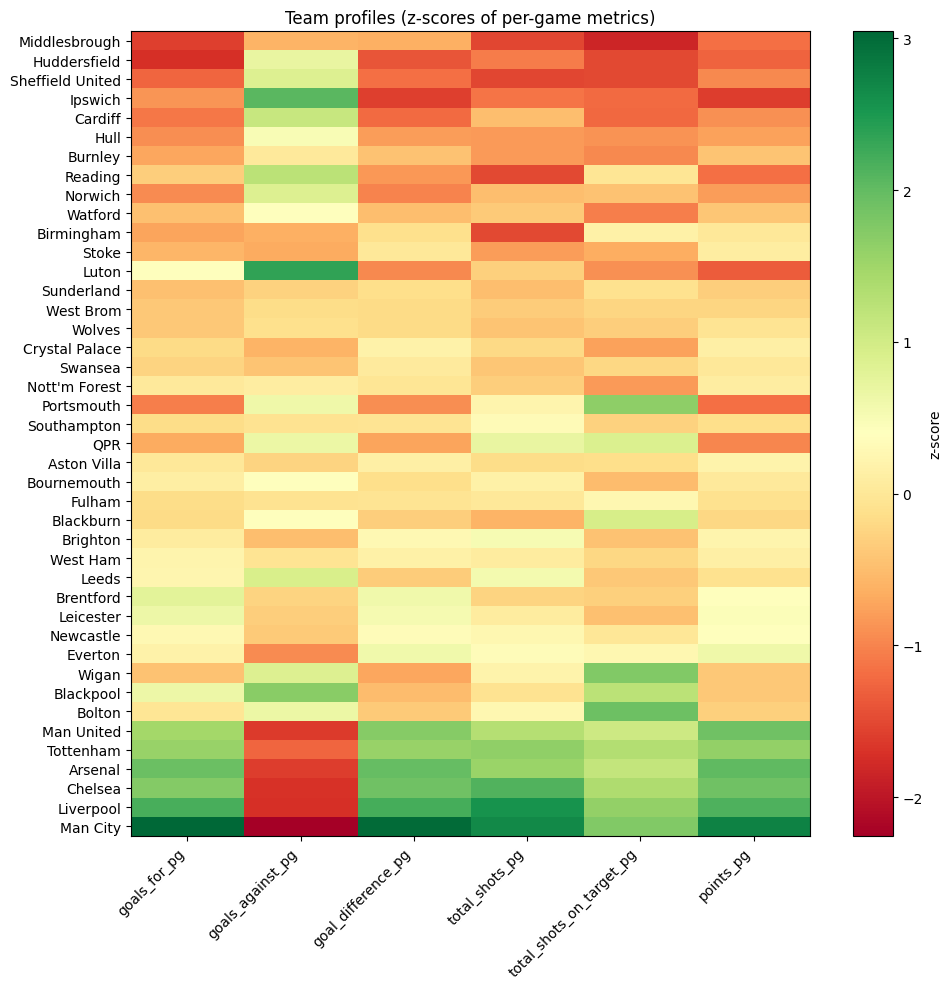

In [55]:
def zscore_heatmap(df, metrics=metrics):
    Z = (df[metrics] - df[metrics].mean()) / df[metrics].std(ddof=0)
    order_rows = np.argsort(Z.values @ np.linspace(1,2,len(metrics)))  # simple ordering
    Z = Z.iloc[order_rows]
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(Z.values, aspect="auto", cmap="RdYlGn")
    ax.set_yticks(range(len(Z))); ax.set_yticklabels(Z.index)
    ax.set_xticks(range(len(metrics))); ax.set_xticklabels(metrics, rotation=45, ha="right")
    ax.set_title("Team profiles (z-scores of per-game metrics)")
    fig.colorbar(im, ax=ax, label="z-score")
    plt.tight_layout(); plt.show()

zscore_heatmap(omega_avg)


## 🎯 Shot Accuracy Analysis: Quality Over Quantity

### The Clinical Finishing Investigation

This visualization examines the relationship between **shot volume** and **shot accuracy** (shots on target percentage). It reveals which teams focus on taking many shots versus those that prioritize high-percentage opportunities.

### Strategic Philosophy Revealed:

**High Volume, High Accuracy Teams:**
- The elite clubs with both creative and clinical players
- Can afford to shoot often because they have skilled finishers
- Usually Manchester City, Liverpool, Arsenal, Chelsea at their best

**High Volume, Low Accuracy Teams:**
- Attacking-minded teams that prioritize getting shots away
- May have pace and creativity but lack clinical finishing
- Often indicates young, inexperienced attacking players

**Low Volume, High Accuracy Teams:**
- Disciplined, selective teams that only shoot when certain
- Counter-attacking specialists who make chances count
- Often defensively solid teams with limited but efficient attacks

### The Modern Football Debate:

This chart addresses the tactical evolution question: **"Is it better to shoot often and accept lower accuracy, or wait for perfect opportunities?"**

- **Pep Guardiola philosophy:** High volume through patient build-up
- **José Mourinho approach:** Clinical efficiency with limited chances
- **Jürgen Klopp style:** Intense pressing creating both volume and accuracy

### Key Insights:
- **Correlation direction** shows if accuracy and volume can coexist
- **Outliers** identify teams with unique tactical approaches
- **Cluster patterns** reveal different strategic philosophies in the Premier League